# Data Acquisition and Preparation

In [1]:
# !pip install -U kaleido
# !pip install pyarabic
# !pip install tashaphyne
# !pip install bertopic
# !pip install transformers
# !pip install gensim
# !pip install WordCloud
# !pip install arabic-reshaper
# !pip install python-bidi

In [2]:
# upload the data
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
df = pd.read_csv("arabic_dataset_classification.csv")
# Dropping null values
df.dropna(axis = 0, inplace = True)
df.rename( columns={"text":"documents"}, inplace = True)
df.head(4)

,documents,targe
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0


In [3]:
# Stratified 1000 sample
# df_sample = df.groupby("targe").apply(lambda x: x.sample(100))
df_sample = df.copy()
df_sample.drop(columns=["targe"], inplace=True)
df_sample.sample(4)

documents
targe                                                         
2     44588  أكد رئيس الحكومة السيد عبد الإله ابن كيران الي...
3     61913  منعت السلطات المغربية تنظيم مظاهرة كانت مقررة ...
4     89203  أفادت مصادر مطلعة الصباح الرياضي أن مجموعة من ...
      65718  نشر موقع يوروسبوت تقريرا طريفا عن أجمل سيدة يت...

In [4]:
# Import needed libraries for this task.
import pandas as pd
from pyarabic.araby import tokenize, is_arabicrange, strip_tashkeel  # to remove non-arabic words, and strip tashkeel
from tashaphyne.stemming import ArabicLightStemmer  # to stem the Arabic words 
from nltk.corpus import stopwords

In [5]:
# function to normalize the Arabic text
def normalize_text(raw_text) -> str:
    '''
    Normalize the arabic text by removing stopwords, non-Arabic words, and Tashkeel
    Parameters:
        raw_text : Arabic text sentence.
    Return:
        normalized_text : normalized Arabic text with removal of Non-Arabic words, Tashkeel, 
    '''
    tokens = tokenize(raw_text, conditions= is_arabicrange, morphs= strip_tashkeel)
    # Obtain the stopwords and create the light stemmer
    ara_stopwords = set( stopwords.words("arabic"))
    ArListem = ArabicLightStemmer()
    # Create a stemmer to get the stem word
    stemmer = lambda word: ArListem.light_stem(word)

    filter_tokens = [stemmer(word) for word in tokens if word not in ara_stopwords]

    return " ".join(filter_tokens)

In [6]:
df_sample["normalized_documents"] = df_sample["documents"].apply(normalize_text)

# Models Preparation

In [7]:
# we define embedding models
from transformers import AutoModel
embedding_model = {
                "AraBert": AutoModel.from_pretrained("aubmindlab/bert-base-arabertv2"), 
                "CAMel": AutoModel.from_pretrained('CAMeL-Lab/bert-base-arabic-camelbert-mix')
            }


In [8]:
# Define dimensionality Reduction Methods
from sklearn.decomposition import PCA, TruncatedSVD
from umap import UMAP
from bertopic.dimensionality import BaseDimensionalityReduction

dim_model = {
            "PCA": PCA( n_components= 5),
            "TruncatedSVD": TruncatedSVD(n_components= 5), 
            "UMAP": UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            "ND": BaseDimensionalityReduction()
        } 


In [9]:
# we define Clustering model
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.cluster import AgglomerativeClustering

'''The Kmeans cluster will be updated with the number of clusters obtained from the HDBSCAN'''
# "Agglomerative": AgglomerativeClustering(n_clusters=50)

cluster_model = {
                "HDBSCAN": HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', 
                                   max_cluster_size=50, allow_single_cluster=True, leaf_size=10),
                "KMeans" : KMeans(n_clusters= 50), 
}


In [10]:
# we define vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer

# Obtaining the Arabic Stopwords into a list
arabic_stopwords = list( set( stopwords.words("arabic")) )
vectorizer_model = CountVectorizer(stop_words=arabic_stopwords, ngram_range=(1, 3), max_df=30, min_df=3)

# vectorizer_model = CountVectorizer(min_df=0.01, max_df=1000)
ctfidf_model = ClassTfidfTransformer()


# Evaluation Metrics Preparation

To evaluate the model topics coherence we use Gensim implementation of the Normalized Pointwise Mutual Information (NPMI).

In [11]:
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora

In [12]:
# Generating Corpus of the documents
texts = [[word for word in str(document).split()] for document in df_sample["documents"]]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

normalized_texts = [[word for word in str(document).split()] for document in df_sample["normalized_documents"]]
normalized_id2word = corpora.Dictionary(normalized_texts)
normalized_corpus = [normalized_id2word.doc2bow(text) for text in normalized_texts]

In [13]:
# compute Coherence score for the topics of the model
def coherence_score(topic_model, normalized):
    extracted_topics = []
    for i in topic_model.get_topics():
        row=[]
        topic = topic_model.get_topic(i)
        for word in topic:
            row.append(word[0])
        extracted_topics.append(row)
        
    if normalized:
        cm = CoherenceModel(topics=extracted_topics, texts=normalized_texts, corpus=normalized_corpus, dictionary=normalized_id2word, coherence='c_npmi')
    else:
        cm = CoherenceModel(topics=extracted_topics, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_npmi')
        
    coherence_score = cm.get_coherence()
    # print('\nCoherence Score: ', coherence)
    return coherence_score

# Visualization Methods

In [14]:
# Function to add the results
# Results Dataframe
regular_results = pd.DataFrame(columns=["embedding", "DR", "Clustering", "NPMI", "TD","Dataset"])
normalized_results = pd.DataFrame(columns=["embedding", "DR", "Clustering", "NPMI", "TD","Dataset"])

def add_result(embedding_model_k, dim_model_k, cluster_model_k, topic_model, normalized):
    ''' Method to add the details of the result of the model trained.'''
    NPMI = coherence_score(topic_model, normalized)
    dataset_norm = "Normalized" if normalized else "raw"
    # Chosing file to add the result to.
    results = normalized_results if normalized else regular_results        
    results.loc[len(results)] = [embedding_model_k, dim_model_k, cluster_model_k, NPMI, None, dataset_norm ]

In [15]:
def topics_visualize(topic_model, name, normalized):
    cluster_img = topic_model.visualize_topics()
    hierarchy_img = topic_model.visualize_hierarchy()
    barchart_img = topic_model.visualize_barchart()
    images = {"clusters":cluster_img,
              "hierarchy":hierarchy_img,
              "barchart":barchart_img}
    norm = "normalized" if normalized else "regular"

    for img_type, image in images.items():
        image_data = image.to_image(format="webp", scale=True)
        image_name = name + "_" + img_type + "_" + norm + ".png"
        with open(image_name, "wb") as f:
            f.write(image_data)

In [16]:
# Function to draw wordCloud
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from wordcloud import WordCloud
import arabic_reshaper


def create_wordcloud(topic_model, name):
    topics_combined = " "
    for i in topic_model.get_topics():
        row=[]
        topic = topic_model.get_topic(i)
        for word in topic:
            row.append(word[0])
        topics_combined = topics_combined + " ".join(row)
    
    data = arabic_reshaper.reshape(topics_combined)
    data = get_display(data)
    wc = WordCloud(font_path='arial', background_color='white',
                  mode='RGB', width=2000, height=1000).generate(data)
    plt.axis("off")
    plt.imshow(wc)
    plt.savefig(name + ".png")

# Permutation of Models

In [17]:
# define customed TF-IDF
counter = 1
permutations = {}
for embedding_model_v in embedding_model:
    for dim_model_v in dim_model:
        for cluster_model_v in cluster_model:
            permutations[counter]= [embedding_model_v, dim_model_v, cluster_model_v]
            counter +=1

In [18]:
permutations

{1: ['AraBert', 'PCA', 'HDBSCAN'],
 2: ['AraBert', 'PCA', 'KMeans'],
 3: ['AraBert', 'PCA', 'Agglomerative'],
 4: ['AraBert', 'TruncatedSVD', 'HDBSCAN'],
 5: ['AraBert', 'TruncatedSVD', 'KMeans'],
 6: ['AraBert', 'TruncatedSVD', 'Agglomerative'],
 7: ['AraBert', 'UMAP', 'HDBSCAN'],
 8: ['AraBert', 'UMAP', 'KMeans'],
 9: ['AraBert', 'UMAP', 'Agglomerative'],
 10: ['AraBert', 'ND', 'HDBSCAN'],
 11: ['AraBert', 'ND', 'KMeans'],
 12: ['AraBert', 'ND', 'Agglomerative'],
 13: ['CAMel', 'PCA', 'HDBSCAN'],
 14: ['CAMel', 'PCA', 'KMeans'],
 15: ['CAMel', 'PCA', 'Agglomerative'],
 16: ['CAMel', 'TruncatedSVD', 'HDBSCAN'],
 17: ['CAMel', 'TruncatedSVD', 'KMeans'],
 18: ['CAMel', 'TruncatedSVD', 'Agglomerative'],
 19: ['CAMel', 'UMAP', 'HDBSCAN'],
 20: ['CAMel', 'UMAP', 'KMeans'],
 21: ['CAMel', 'UMAP', 'Agglomerative'],
 22: ['CAMel', 'ND', 'HDBSCAN'],
 23: ['CAMel', 'ND', 'KMeans'],
 24: ['CAMel', 'ND', 'Agglomerative']}

# Execution

In [19]:
def apply_model(permu_no, documents, normalized):
    '''Method to apply each permutation individually, to identify errors'''

    topic_model = BERTopic( embedding_model= embedding_model[permutations[permu_no][0]],
            umap_model= dim_model[permutations[permu_no][1]], 
            hdbscan_model= cluster_model[permutations[permu_no][2]],
            vectorizer_model= vectorizer_model,
            ctfidf_model=ctfidf_model
            )   
    topic_model.fit_transform(documents)
    # Save results
    add_result(permutations[permu_no][0], permutations[permu_no][1], permutations[permu_no][2], topic_model, normalized)

    # Save wordcloud
    norm = "normalized" if normalized else "regular"
    name = norm + "_" + permutations[permu_no][0] + "_" + permutations[permu_no][1] + "_" + permutations[permu_no][2] 
    # Visualize topics
    create_wordcloud(topic_model, name)
    topics_visualize(topic_model, name, normalized)

# Running Tests

In [20]:
df_sample

documents  \
targe                                                             
0     5019    عبدالاله بوسحابة اخبارنا المغربية بعيدا عن الب...   
      11458   قالت الكاتبة جيه كيه رولينغ مؤلفة روايات هاري ...   
      11405   أثارت مشاركة فنانين عرب في الأعمال الدرامي َّ ...   
      11501   نال الكاتب الفرنسي المغربي الطاهر بن جلون جائز...   
      4322    عبدالاله بوسحابة اخبارنا المغربية بشكل مفاجئ ل...   
...                                                         ...   
4     98433   ضم حسنية أكادير اللاعب الواعد حميد أحداد من فر...   
      108668  عبر نادي نيس الفرنسي عن رغبته في تحويل عقد صان...   
      105909  عين النادي القنيطري طارق شهاب مدربا مساعدا للف...   
      100016  شباط يسبق أوزين في الاحتفاء بالماص واللاعبون ي...   
      80553   عقد الفرنسي هيرفي رونار الناخب الوطني المغربي ...   

                                           normalized_documents  
targe                                                            
0     5019    عبدالال وسحاب خبار مغرب عيدا برامج رمضان عرض ق...  
      11458   قال كاتب جي يه رولينغ مؤلف روا هار وتر مسرح ها...  
      11405   ثار مشارك نان عرب أعمال درام  مغرب سخط وسط فن ...  
      11501   نال كاتب فرنس مغرب طاهر بن جل جائز ري ماري ريم...  
      4322    عبدالال وسحاب خبار مغرب شكل مفاجئ غا هاجم فن م...  
...                                                         ...  
4     98433   ضم حسن كادير لاعب واعد حميد حداد ريق درار سوس ...  
      108668  عبر ناد يس فرنس رغب حويل عقد صانع عاب مغرب ونس...  
      105909  ناد قنيطر طارق شهاب مدرب مساعد فرنس جو غا ليم ...  
      100016  سبق زي احتفاء ماص لاعب طلب إفراج مستحق قيم محم...  
      80553   عقد فرنس هيرف رونار ناخب وطن مغرب يوم جمع قاع ...  

[500 rows x 2 columns]

In [21]:
# Testing with various permutations
import multiprocessing.process
import threading

def test_regular_documents():
    # run over the permutations passing raw text.
    # 1- create tests run file 
    regular_documents = pd.DataFrame(columns=["Permutation", "Status", "Exception"])
    for i in permutations:
        try:
            apply_model(i, df_sample["documents"], False)
            regular_documents.loc[len(regular_documents)] = [permutations[i], "Success", None]
        except Exception as e:
            regular_documents.loc[len(regular_documents)] = [permutations[i], "Failure", str(e)]
        
        print(f"Passed regular case No. {i}:{permutations[i]}")

    # save the test results to csv files
    regular_documents.to_csv("Regular Documents Run Results.csv")
    regular_results.to_csv("regular documents tests results.csv")

def test_normalized_documents():
    # run over the permutations passing raw text.
    # 1- create tests run file 
    normalized_documents = pd.DataFrame(columns=["Permutation", "Status", "Exception"])
    for i in permutations:
        try:
            apply_model(i, df_sample["normalized_documents"], True)
            normalized_documents.loc[len(normalized_documents)] = [permutations[i], "Success", None]
        except Exception as e:
            normalized_documents.loc[len(normalized_documents)] = [permutations[i], "Failure", str(e)]
        
        print(f"Passed normalized case No. {i}:{permutations[i]}")
    # save the results to the
    normalized_documents.to_csv("Normalized Documents Run Results.csv")
    normalized_results.to_csv("normalized documents tests results.csv")


Passed regular case No. 1:['AraBert', 'PCA', 'HDBSCAN']
Passed normalized case No. 1:['AraBert', 'PCA', 'HDBSCAN']
Passed normalized case No. 2:['AraBert', 'PCA', 'KMeans']
Passed regular case No. 2:['AraBert', 'PCA', 'KMeans']
Passed normalized case No. 3:['AraBert', 'PCA', 'Agglomerative']
Passed regular case No. 3:['AraBert', 'PCA', 'Agglomerative']
Passed normalized case No. 4:['AraBert', 'TruncatedSVD', 'HDBSCAN']
Passed regular case No. 4:['AraBert', 'TruncatedSVD', 'HDBSCAN']
Passed normalized case No. 5:['AraBert', 'TruncatedSVD', 'KMeans']
Passed normalized case No. 6:['AraBert', 'TruncatedSVD', 'Agglomerative']
Passed regular case No. 5:['AraBert', 'TruncatedSVD', 'KMeans']
Passed normalized case No. 7:['AraBert', 'UMAP', 'HDBSCAN']
Passed regular case No. 6:['AraBert', 'TruncatedSVD', 'Agglomerative']
Passed normalized case No. 8:['AraBert', 'UMAP', 'KMeans']
Passed regular case No. 7:['AraBert', 'UMAP', 'HDBSCAN']
Passed normalized case No. 9:['AraBert', 'UMAP', 'Agglomerat

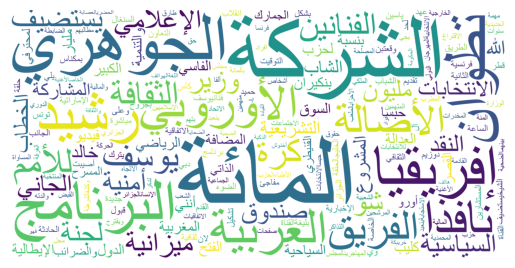

In [22]:
# Initiate two processes
# p1 = multiprocessing.Process( target=test_regular_documents )
# p2 = multiprocessing.Process(target=test_normalized_documents)
# ---- Trying with threading
p1 = threading.Thread( target=test_regular_documents )
p2 = threading.Thread(target=test_normalized_documents)


# start the two processes
p1.start()
p2.start()

# join the two processes
p1.join()
p2.join()

# Finished 
print("Done!!")


In [23]:
while p1.is_alive() or p2.is_alive():
    print("Still working...")

# Sample Testing

In [24]:
# number = 2
# print(f"test case:{permutations[number]}")
# topic_model = BERTopic( embedding_model= embedding_model[permutations[number][0]],
#         umap_model= dim_model[permutations[number][1]], 
#         hdbscan_model= cluster_model[permutations[number][2]],
#         vectorizer_model= vectorizer_model,
#         ctfidf_model=ctfidf_model
#         )
# topics, probs = topic_model.fit_transform(df_sample["normalized_documents"])


In [25]:
# topics_visualize(topic_model, "KK",True)

In [26]:
# create_wordcloud(topic_model, "Hello")

In [27]:
# coherence_score(topic_model, True)